<div class="alert alert-block alert-info">
Wall Street Bets Sentiment Analysis 12/01 - 12/12/2020
</div> 
<img width="500" height="600" src = https://i.kym-cdn.com/entries/icons/original/000/033/559/cover1.jpg>
<p>By: Mahi Mulpuri and Yueshan Wang</p>

<p>Objectives:</p>
<ol>
  <li style = "color: green">Scrape Reddit data from Wall Street Bets, a subreddit on Reddit, to aggregate general market sentiment about stocks</li>
  <li style = "color: blue">Visualize scraped data to gain understanding about certain stocks and future trends within market</li>
  <li style = "color: red">Perform some basic ML to shed some light about what might be good 'due diligence' on stocks, and what good due diligence might look like</li>
</ol>
<p><strong>Motivation</strong></p>
<p>The main motivation for this project lies behind gaining some intuition on what general consensus among novice traders might be. One might say this is a fruitless principle as novice traders often make very little reasonable trades based on classic trading princples, however some hedge funds such as Citadel might say otherwise. Over the past few years Citadel has entered into a contract allowing them the sole ability to buy data from Robinhood a trading platform used mostly by novice traders and most of the people on Wall Street Bets. The idea is that data on what novice traders might be doing in the right hands can be very worthwhile in determining good systematic trading strategies. For example, in the project we will show a lot of interest in the stock PLTR within this time period that has very high volatility and a large margin for algo traders to make off of it.</p>

<div style = "background-color: lightgreen;">
    <p style = "font-size: 20px"><strong>Scraping Data</strong></p>
</div>
<p> In the following two cells we will scrape data from a number of 'daily discussion posts' on Wall Street Bets and put this data into a dataframe for visualization later on. We will collect comments, users, time stamps, karma, and lastly interaction via replies. </p>

We will use Python 3 as well as some pandas, numpy, matplotlib, seaborn, praw, scikit-learn and math and datetime to handle data from reddit

In [1]:
import praw
import re
import pandas as pd
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
import numpy as np

reddit = praw.Reddit(
    client_id="DxS7Nu00NAKTzA",
    client_secret="nrSj-VrF5j7YiGMfftFAYTO6eMXOvw",
    user_agent="school project"
)

posts = ['k4ixya','k57d6a','k5vaj4','k6j06n','k6tl0d','k8el96','k92ab0','k9pwht','kadem4','kb0pf8','kbb812']
all_posts1 = []
for post in posts:
    print("loading post " + post)
    i = 1
    submission = reddit.submission(id = post)
    submission.comment_sort = "top"
    submission.comments.replace_more(limit=2)
    for comment in submission.comments.list():
       
        try:
        
            all_posts1.append([comment.author, comment.author.comment_karma, datetime.datetime.fromtimestamp(comment.created_utc), comment.body, comment.score, comment.distinguished, len(comment.replies), i, post, comment.body])
       
        except Exception:
            all_posts1.append(['deleted', 'deleted',datetime.datetime.fromtimestamp(comment.created_utc),comment.body, comment.score,comment.distinguished,len(comment.replies),i,post, comment.body])
            
        i = i + 1
wsb2 = pd.DataFrame(all_posts1,columns=['redditor', 'karma','time' ,'comment','upvotes','gilded','interaction','rank','post_id', 'tickers'])
wsb2.head()

loading post k4ixya
loading post k57d6a
loading post k5vaj4
loading post k6j06n
loading post k6tl0d
loading post k8el96
loading post k92ab0
loading post k9pwht
loading post kadem4
loading post kb0pf8
loading post kbb812


,redditor,karma,time,comment,upvotes,gilded,interaction,rank,post_id,tickers
0,EatMaTesticles,11187,2020-12-01 06:50:02,Can you imagine SEC officials reading this sub...,316,None,2,1,k4ixya,Can you imagine SEC officials reading this sub...
1,AFruitShopOwner,46665,2020-12-01 06:13:37,I'm over-leveraged and underinformed 🚀,240,None,1,2,k4ixya,I'm over-leveraged and underinformed 🚀
2,TOADSTOOL__SURPRISE,92737,2020-12-01 06:33:41,I was in the club last night scrolling through...,195,None,1,3,k4ixya,I was in the club last night scrolling through...
3,Catheter_Trader,2509,2020-12-01 06:18:33,#STONKS GO UP FUCK YOUR PUTS,153,None,1,4,k4ixya,#STONKS GO UP FUCK YOUR PUTS
4,MorpheusOnAcid,9916,2020-12-01 07:36:26,Atleast at the casino there's cool flashing li...,154,None,1,5,k4ixya,Atleast at the casino there's cool flashing li...


<p><strong>Need to pip install get_all_tickers to grab stock ticker symbols</strong></p>

<a href= https://github.com/shilewenuw/get_all_tickers> click here to read more about get_all_tickers</a>

When the data from reddit is first added to our data frame the "comment" column and "tickers" column are the same.
Before we match tickers in comments with stocks we need to import a list of stocks using get_all_tickers. We use the get_all_tickers_filtered function with a minimum market cap of \\$1 billion in order to only get companies with a greater market cap than \\$1 billion.

We have also created a short list of common words that should be excluded from our list of tickers such as "ARE" and "HAS".

We will preprocess this data from reddit by cross checking any words in the comment with stock tickers using our list of tickers we imported. We use a regex that matches any 2-5 character word whose first character is capitalized.

In [2]:
# Cross check valid stock ticker symbols mentions from list
from get_all_tickers import get_tickers as gt
list_of_tickers = gt.get_tickers_filtered(mktcap_min = 1000)
lookup = set(list_of_tickers)

common_words = ["HAS","MAN", "BRO", "ARE", "SO", "IT", "GO", "HE", "SHE", "OUT", "HOPE", "NOV", "AIR", "ON", "OR", "ALL", "NOW"]

wsb = wsb2.copy(deep = True)
for index, row in wsb.iterrows():
    reg_tickers = re.findall(r'[$][A-Z][\S]*', row['tickers'])
    reg_tickers = [e[1:] for e in reg_tickers]
    other_tickers =  re.findall(r'\b[A-Z][a-zA-Z]{1,4}\b', row['tickers'])
    all_tick = reg_tickers + other_tickers
    final = []
    for tick in all_tick:
        if tick.upper() in lookup and tick.upper() not in common_words:
            final.append(tick.upper())
    wsb.at[index, 'tickers'] = final
    

<div style = "background-color: lightblue;">
    <p style = "font-size: 20px"><strong>Visualizing Data</strong></p>
</div>
<p> In the following cells we will be taking a look at what users on Wall Street Bets are most interested in. Also we will be running a few regressions on the most interested stocks! From this information we can draw some ideas on what stocks we should be making plays on.</p>

In [3]:
#for index, row in wsb.iterrows():
   # wsb.at[index,'time']  = row['time']

freq = {}
for index, row in wsb.iterrows():
    for tick in row['tickers']:
        if tick in freq:
            freq[tick] = freq[tick] + 1
        else:
            freq[tick] = 1
freq_df = pd.DataFrame(freq.items(), columns=['Stock', 'Mentions'])

<p><strong>In this simple graph, we can see the stocks with the most buzz around them are as follows for this time period:
PLTR, TSLA, GME, NIO, ABNB, RH. We will be focussing on the first 5 for the rest our analysis!</strong></p>

<AxesSubplot:title={'center':'Stock vs Mentions'}, xlabel='Stock'>

<Figure size 1440x864 with 0 Axes>

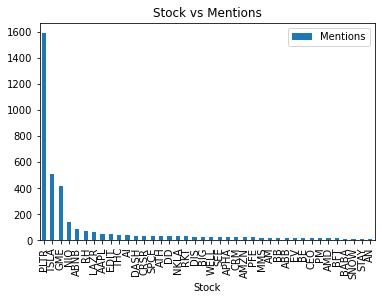

In [4]:

freq_df = freq_df.sort_values(by=['Mentions'], ascending = False)
freq_df = freq_df.head(40)
freq_df.plot(kind='bar', x = "Stock", title = "Stock vs Mentions")

In [5]:
fetch_stocks = freq_df['Stock'].to_list()


<p><strong>Need to pip install yfinance</strong></p>

In [6]:
import yfinance as yf
data = yf.download(fetch_stocks, start="2020-12-01", end="2020-12-20")

[*********************100%***********************]  40 of 40 completed


<p><strong>In the following cells, we plot sentiment overtime against the price of the stock over time. We can establish some pretty strong correlation visually between the movement of a stock and interest in it. We can see that overtime as a stock is increasing in price interest usually seems to pick up as it peaks around the 'bull flag' and tapers off as the price of the stock also falls. This type of data can be used to understand rudimentary trades about some stocks. A basic idea is that volatility is sure to follow stocks that sentiment increases from our sample set.</strong></p>

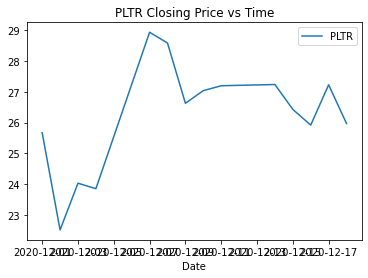

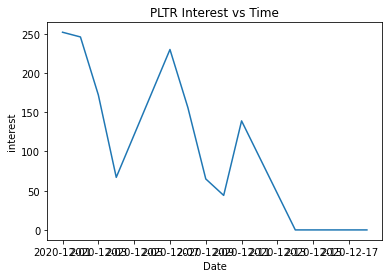

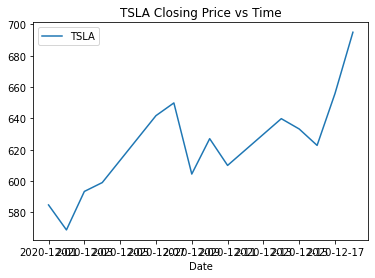

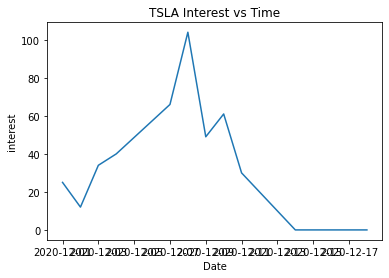

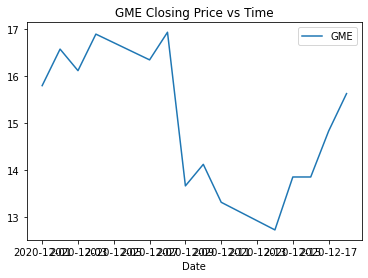

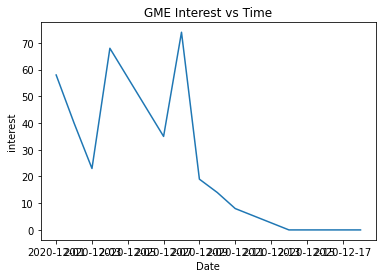

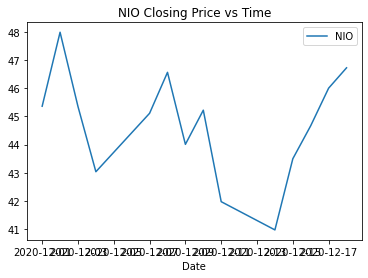

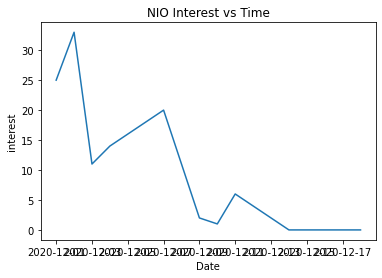

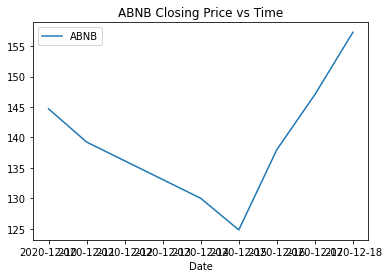

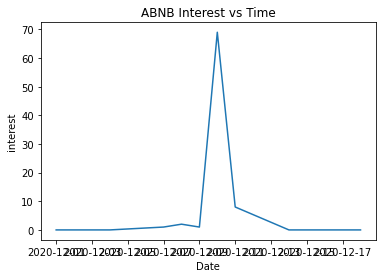

In [7]:
def aggregate_interest(s):
    stock_time = {}
    for index, row in wsb.iterrows():
        if s in row['tickers']:
            date = str(row['time'].date())
            if date in stock_time:
                stock_time[date] = stock_time[date] + 1
            else:
                stock_time[date] = 1
    df = data.filter([('Adj Close', s),('Close', s),('High', s),('Low', s),('Open', s),('Volume', s)], axis=1)
    toAppend = []
    for i, row in df.iterrows():
        if str(i.date()) in stock_time:
            toAppend.append(stock_time[str(i.date())])
        else:
            toAppend.append(0)
    df['interest'] = toAppend
    plt.figure()
    f1 = sns.lineplot(data=df["Close"])
    f1.set(title=s + ' Closing Price vs Time')
    plt.figure()
    f2 = sns.lineplot(data=df["interest"])
    f2.set(title=s + ' Interest vs Time')
   
    res1 = f1.get_figure()
    res2 = f2.get_figure()
    return (res1,res2)

# top 5 interest
for i in range(0, 5):
    (res1, res2) = aggregate_interest(fetch_stocks[i])



<p><strong>In the following cells we take a look at general sentiment among the users of wall street bets. The way we define the upward vector of sentiment is that comments mentioning a 'call' signify long(or short) term belief that the stock they are referring to will rise in price, whereas 'put' refers to a stock they believe will drop in the short or long term depending on their strike date. Moreover, notice how bear is actually used in our upward calculation, interestingly enough comments mentioning a bear actually appear to signify that the user hold the opposite belief that the market is going up and that bears are wrong, and vice versa for bulls. From the general sentiment graph we can see that around the middle of our time period 12/05 - 12/07 is when the market was filled with the most opposing opinions as our vector neared 0. Leading up to this point and following it we can assume that the market was short, then long respectively.</strong></p>

In [8]:

# general market sentiment using LFs
calls_up = []
puts_down = []
for i, row in wsb.iterrows():
    search = row['comment'].upper()
    if 'CALL' in search or 'CALLS' in search or 'BOUGHT' in search or 'UP' in search or 'LONG' in search or 'BEAR' in search or 'BEARS' in search:
        calls_up.append(1)
    else:
        calls_up.append(0)
    if "PUT" in search or "PUTS" in search or "SOLD" in search or "DOWN" in search or "SHORT" in search or "BULL" in search or 'BULLS' in search:
        puts_down.append(1)
    else:
        puts_down.append(0)

Text(0.5, 1.0, 'General Sentiment')

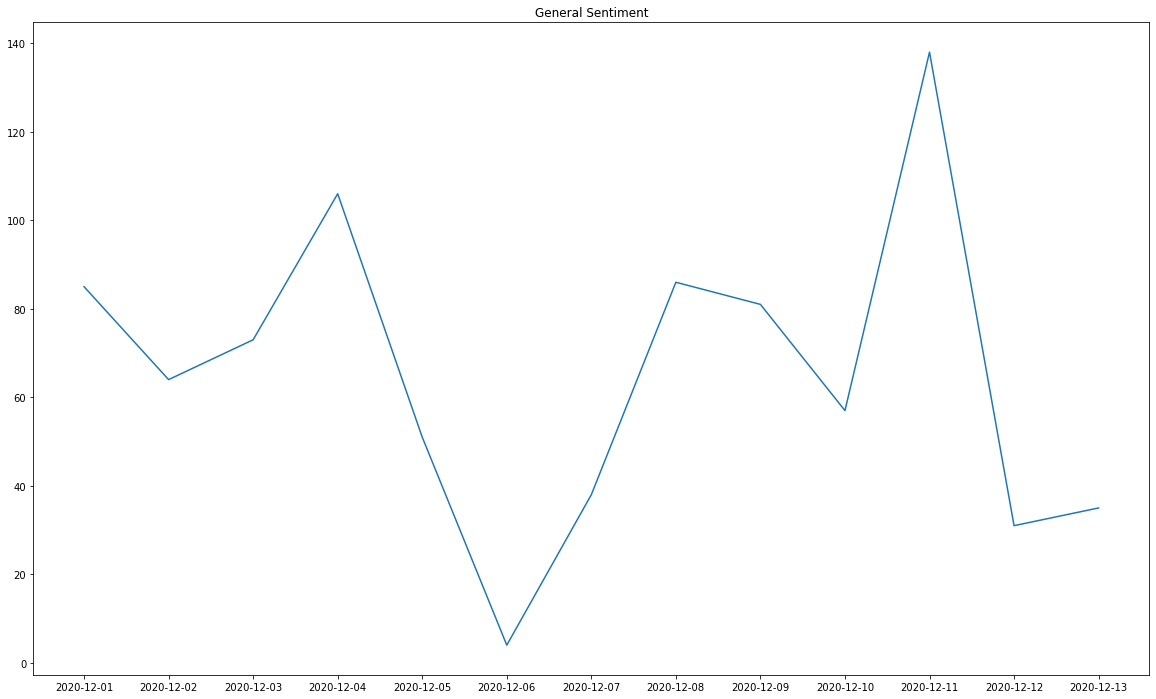

In [17]:
wsb['upwards'] = calls_up
wsb['downwards'] = puts_down

overall_trend = {}
for i, row in wsb.iterrows():
    lookup = str(row['time'].date())
    if lookup in overall_trend:
        overall_trend[lookup] = overall_trend[lookup] + (row['upwards'] - row['downwards'])
    else:
        overall_trend[lookup] = (row['upwards'] - row['downwards'])
    
dates = list(overall_trend.keys())
vals = list(overall_trend.values())
plt.figure(figsize=(20,12))

plt.plot_date(dates, vals, '-')
plt.title("General Sentiment")

<p><strong>From this we can see that the market is generally more bullish in the eyes of those at wall street bets and calls dominate the mentions of puts overall. </strong></p>

Text(0.5, 1.0, 'Calls v Puts')

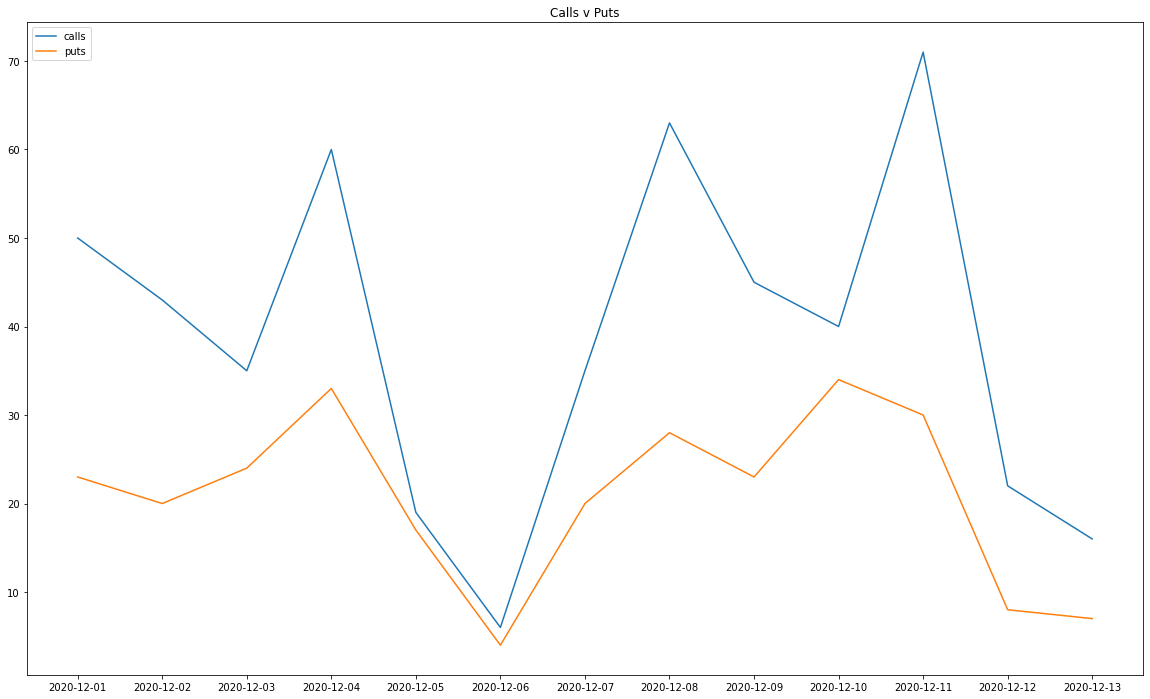

In [22]:
# Analyze puts v calls


calls= []
puts=[]
for i, row in wsb.iterrows():
    search = row['comment'].upper()
    if "CALL" in search or "CALLS" in search:
        calls.append(1)
    else:
         calls.append(0)
    if "PUT" in search or "PUTS" in search:
        puts.append(1)
    else:
        puts.append(0)
wsb['call?'] = calls
wsb['put?'] = puts
calls_d = {}
puts_d = {}
for i, row in wsb.iterrows():
    lookup = str(row['time'].date())
    if lookup in calls_d:
        calls_d[lookup] = calls_d[lookup] + row['call?']
        puts_d[lookup] = puts_d[lookup] + row['put?']
    else:
        calls_d[lookup] = row['call?']
        puts_d[lookup] = row['put?']
c_dates = list(calls_d.keys()) 
c_vals = list(calls_d.values())
p_dates = list(puts_d.keys()) 
p_vals = list(puts_d.values())
plt.figure(figsize=(20,12))

plt.plot_date(c_dates, c_vals, '-', label = "calls")
plt.plot_date(p_dates, p_vals, '-', label = "puts")
plt.legend(loc = "upper left")
plt.title("Calls v Puts")

In [11]:
#sentiment for a given stock
def stock_sentiment(s):
    sentiment = {}
    for i, row in wsb.iterrows():
        if s in row['tickers']:
            search = row['comment'].upper()
            datetime = str(row['time'].date())
            
            call_up = 0
            put_down = 0
            
            if 'CALL' in search or 'CALLS' in search or 'BOUGHT' in search or 'UP' in search or 'LONG' in search or 'BEAR' in search or 'BEARS' in search:
                call_up = 1
            if "PUT" in search or "PUTS" in search or "SOLD" in search or "DOWN" in search or "SHORT" in search or "BULL" in search or 'BULLS' in search:
                put_down = 1

                
            if datetime in sentiment:
                sentiment[datetime] = sentiment[datetime] + call_up - put_down
            else:
                sentiment[datetime] = call_up - put_down
                
          
    dates = list(sentiment.keys())
    vals = list(sentiment.values())
    
   
    return (dates, vals)

<p><strong>Here we will fit prices to dates, interest, and sentiment via linear regression(OLS). To understand future trajectory of the most mentioned stocks.</strong></p>

This function will try and fit prices with time to predict future prices


In [12]:
def lin_reg_time(s):
    
    clf = linear_model.LinearRegression()

    df = data.filter([('Close', s)])
    prices = []

    datetimes = []
    array = []

    for d in df.iloc[:,0]:
        if not math.isnan(d):
            prices.append(d)
            array.append(1)
        else:
            array.append(-1)
        
    index = 0
        
    for i,j in df.iterrows():
        if array[index] == 1:
            datetimes.append(i.date())
        index = index+1
        
    

    plt.figure(figsize=(20,12))
 
    plt.plot(datetimes, prices, 'o')
    

    datetimes_ = []
    
    for day in datetimes:
        datetimes_.append([day.day])
    
    clf.fit(datetimes_, prices)


    predict = clf.predict(datetimes_)

    
    plt.plot(datetimes,predict)
    plt.title("price of " + s +  " over time")
    plt.xlabel("day")
    plt.ylabel("price")
    plt.show()


This function will try and fit prices with interest to predict future prices. Interest is measured as the number of times a stock is mentioned by name

In [13]:
def lin_reg_interest(s):
    clf = linear_model.LinearRegression()
        
    stock_count = {}
    #counting up stock mentions
    for index, row in wsb.iterrows():
        if s in row['tickers']:
            date = str(row['time'].date())
            if date in stock_count:
                stock_count[date] = stock_count[date] + 1
            else:
                stock_count[date] = 1
        
    

    df = data.filter([('Close', s)])
    
    
    toAppend = []
    
    
    for i, row in df.iterrows():
        if str(i.date()) in stock_count:
            toAppend.append(stock_count[str(i.date())])
        else:
            toAppend.append(0)
    
    prices = []

    index = 0
    
    for i,j in df.iterrows():
        if not math.isnan(j):
            prices.append(j)
        else:
            toAppend[index] = -1
        index = index+1
        
    interest_ = []
    
    for i in toAppend:
        if  i != -1:
            interest_.append([i])
        
    
    plt.figure(figsize=(20,12))

    plt.plot(interest_, prices, 'o')

    clf.fit(interest_, prices)

    predict = clf.predict(interest_)

    plt.plot(interest_,predict)
    plt.title("price of " + s +  " versus interest")
    plt.xlabel("Interest")
    plt.ylabel("Price")
    plt.show()
    
    

This function will try and fit prices with sentiment as measured by the stock_sentiment function defined earlier.

In [14]:
def lin_reg_sentiment(s):
    clf = linear_model.LinearRegression()

    print(s)
    #vals is sentiment
    (dates, vals) = stock_sentiment(s)
    df = data.filter([('Close', s)])

    prices = []
            
    for i in df[("Close",s)]:
        if not math.isnan(i):
            prices.append(i)

    if(len(vals) < len(prices)):
        prices = prices[0:len(vals)]
    else:
        prices.append(0)
    
    plt.figure(figsize=(20,12))

    plt.plot(vals, prices, 'o')

    vals_ = []
    for v in vals:
        vals_.append([v])
    
  
    clf.fit(vals_, prices)
    
    predict = clf.predict(vals_)

    plt.plot(vals_,predict)
    plt.title("price of " + s +  " versus Sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel("Price")
    plt.show()



Running linear regressions on some sample stocks

These graphs can give us some general observations of stock prices during this time period.


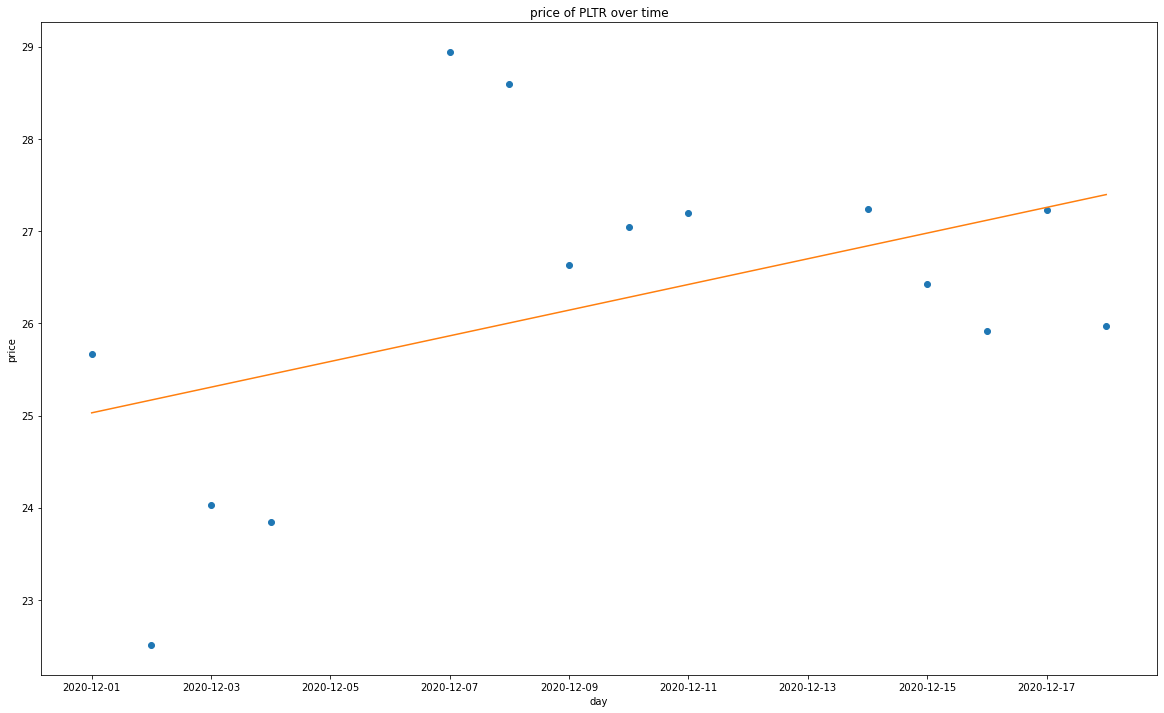

PLTR


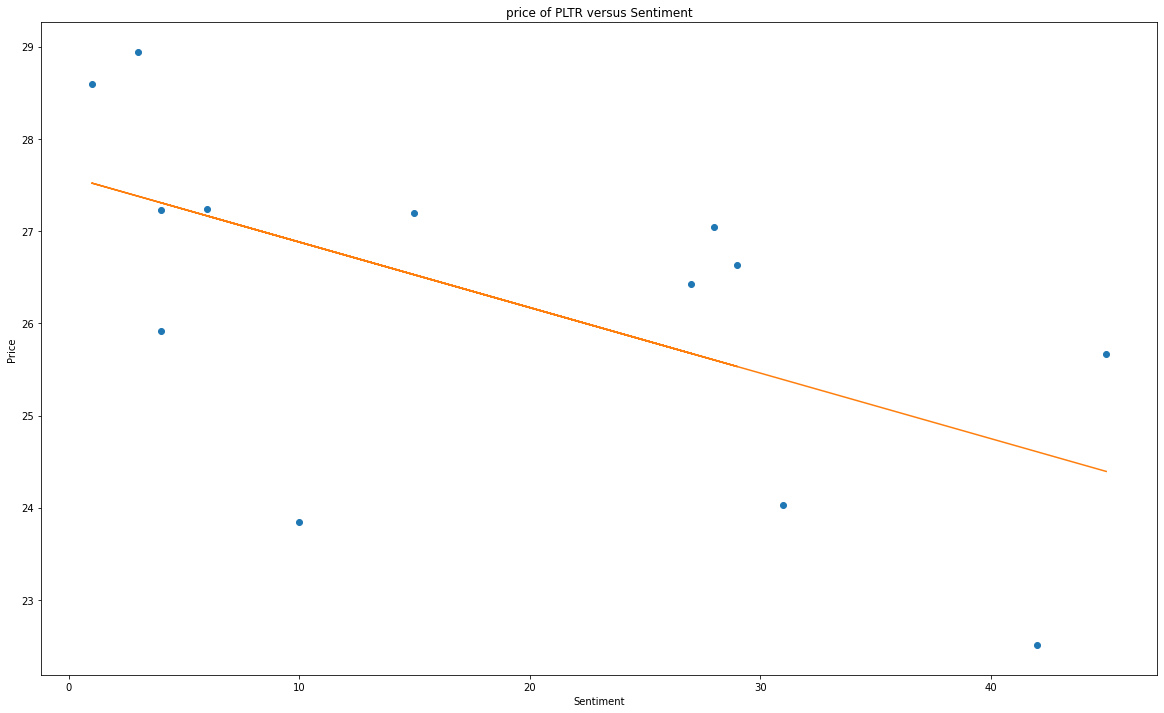

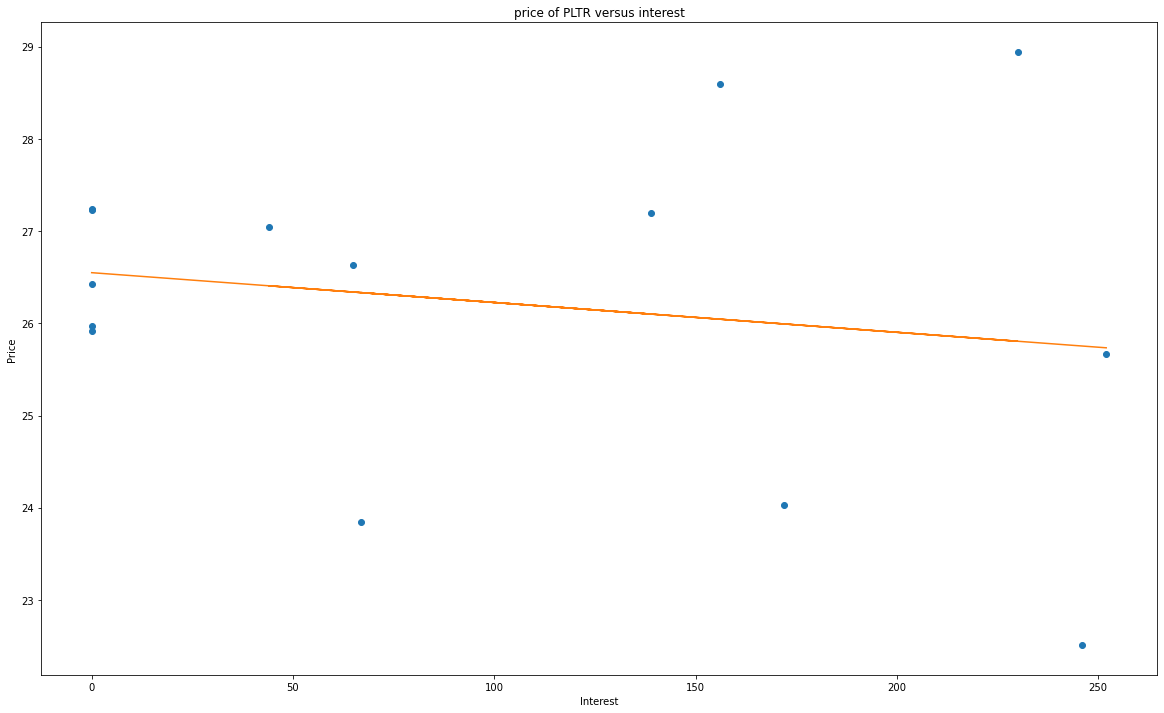

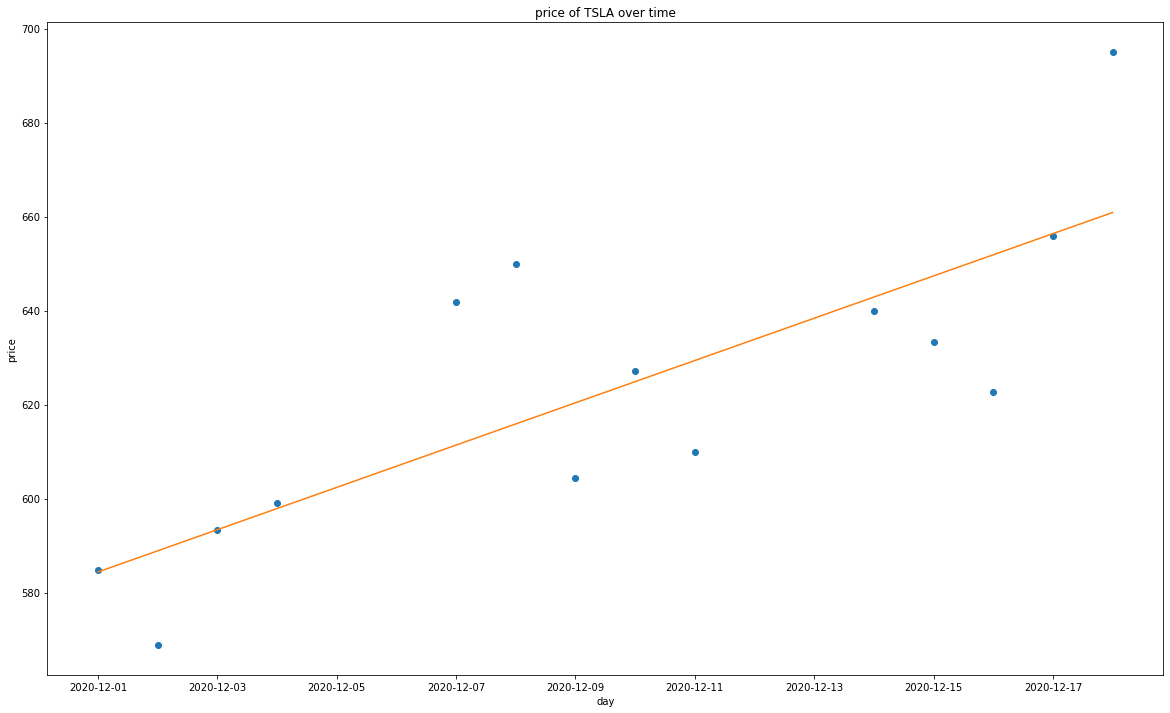

TSLA


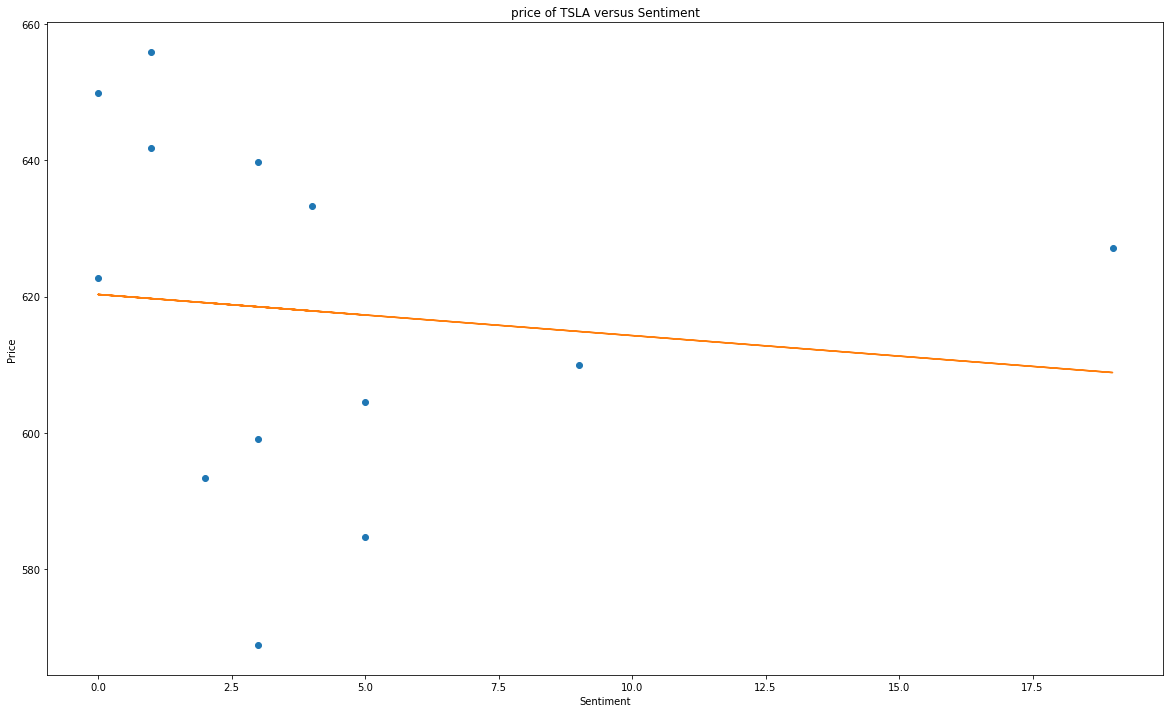

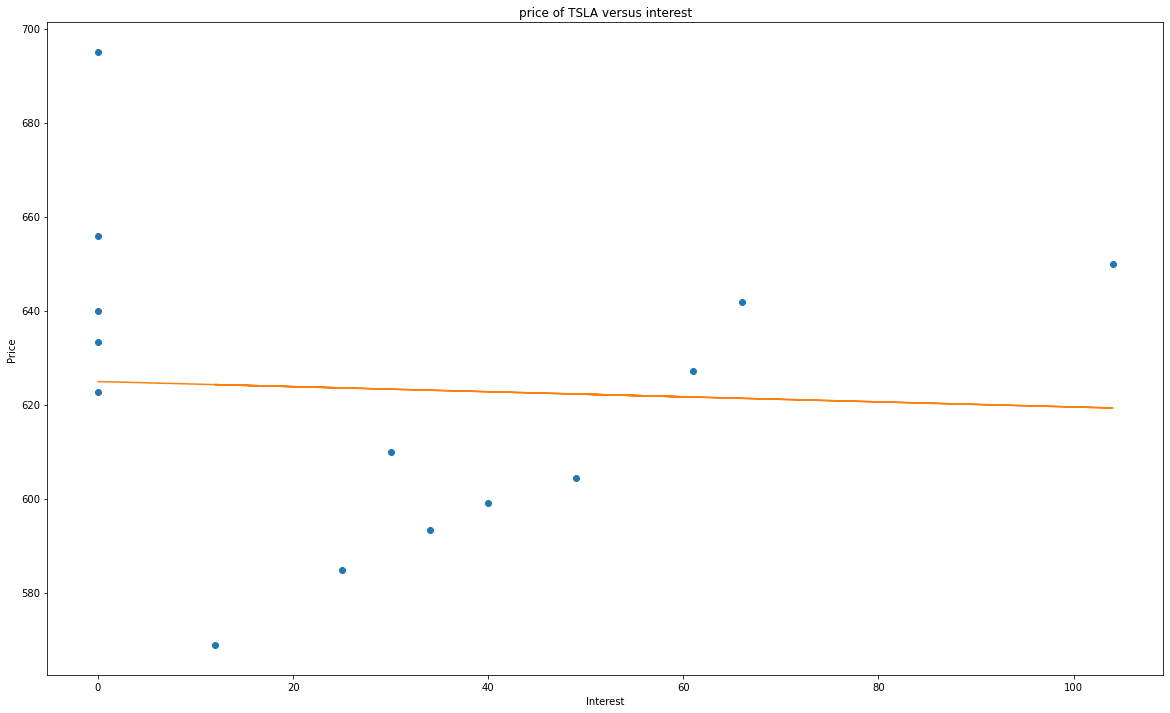

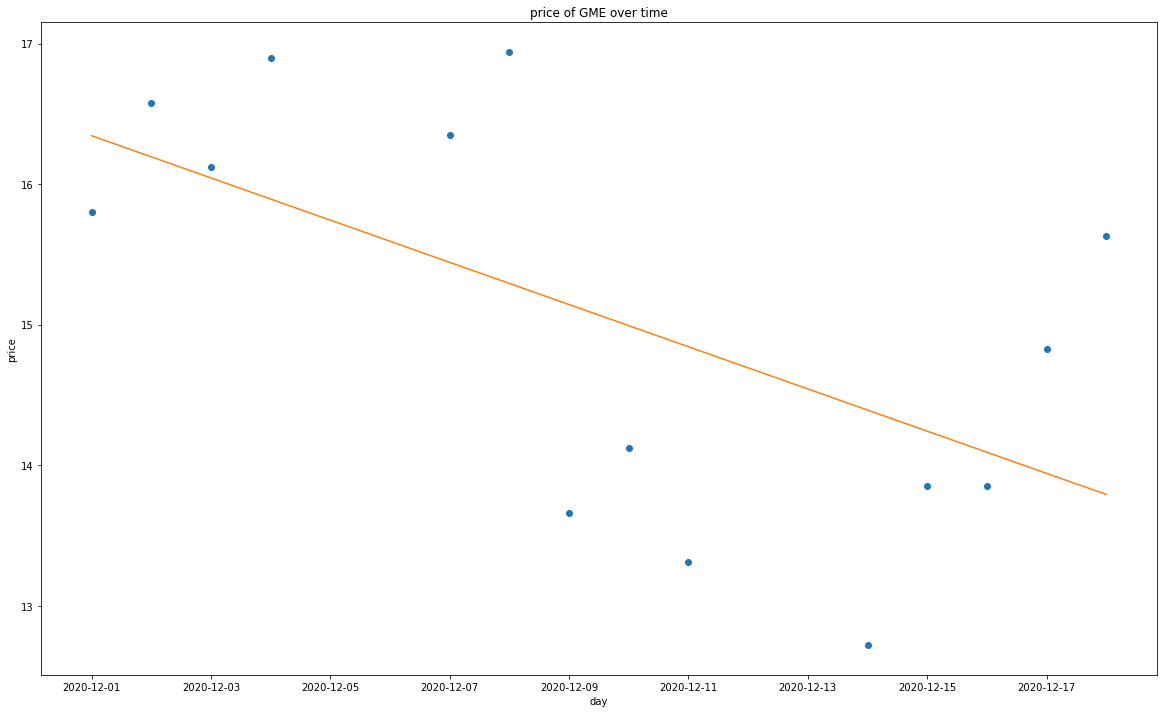

GME


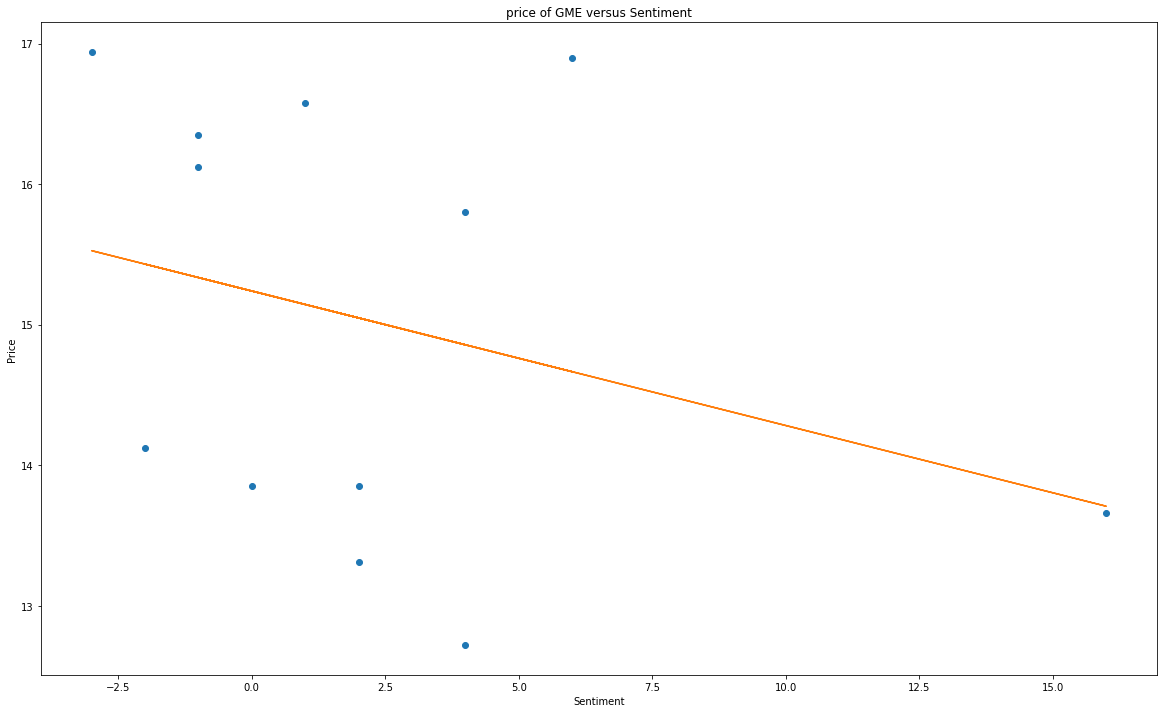

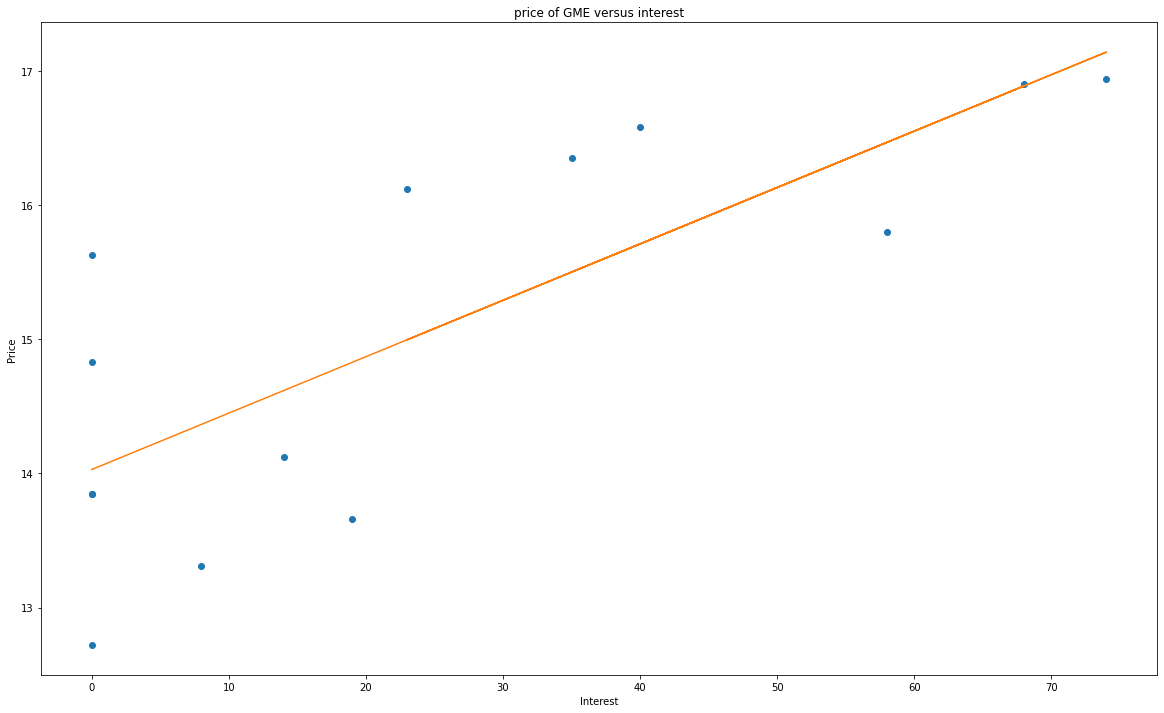

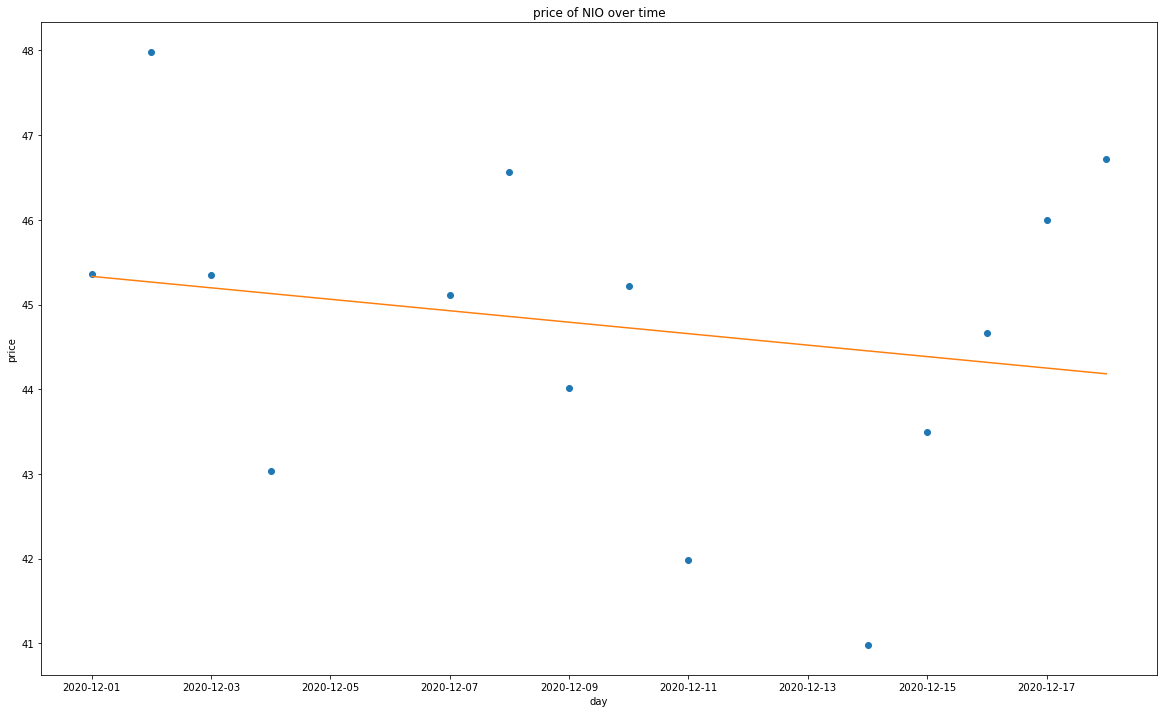

NIO


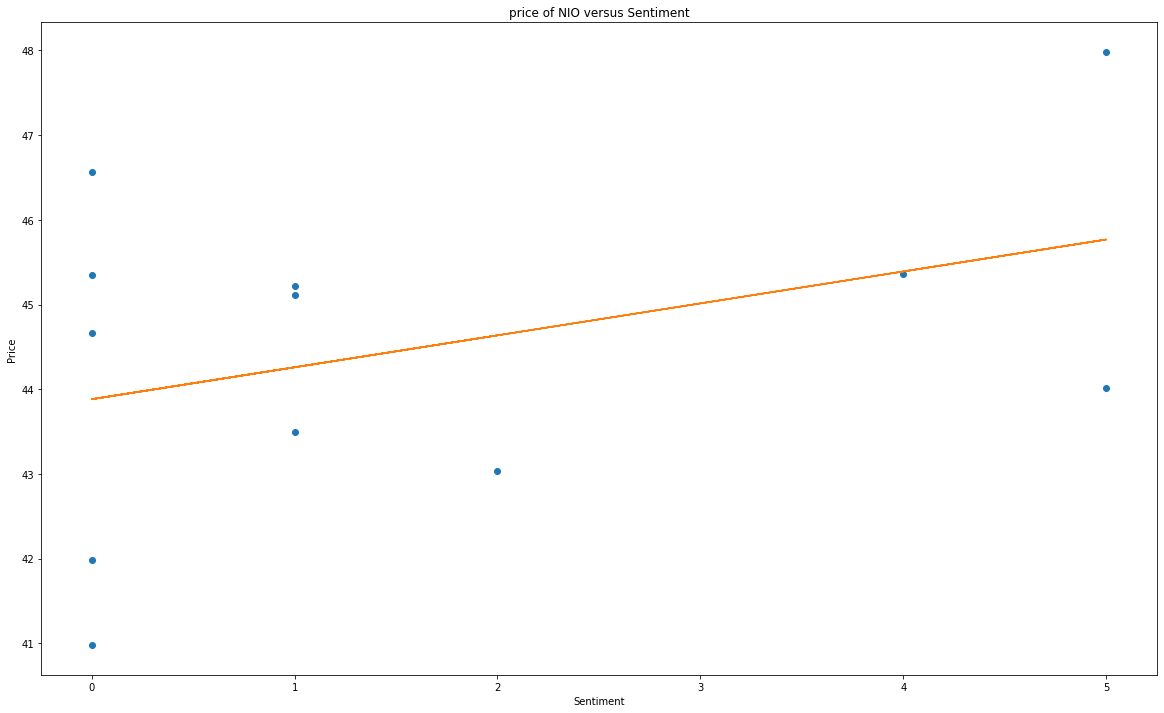

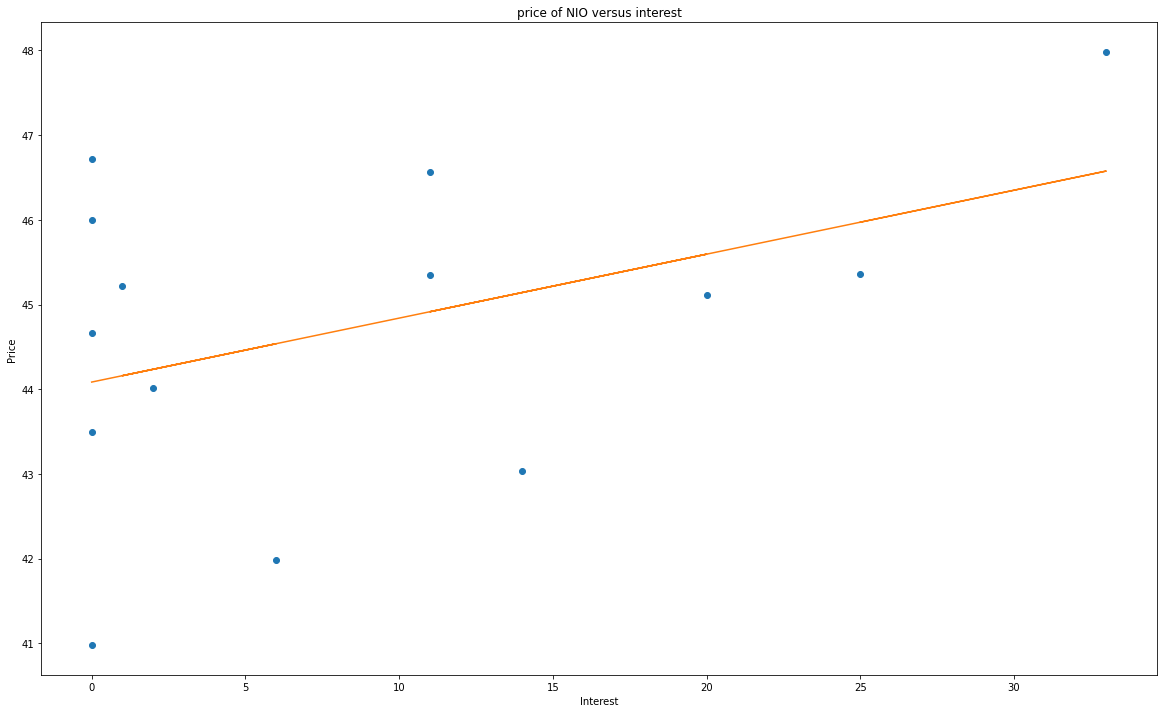

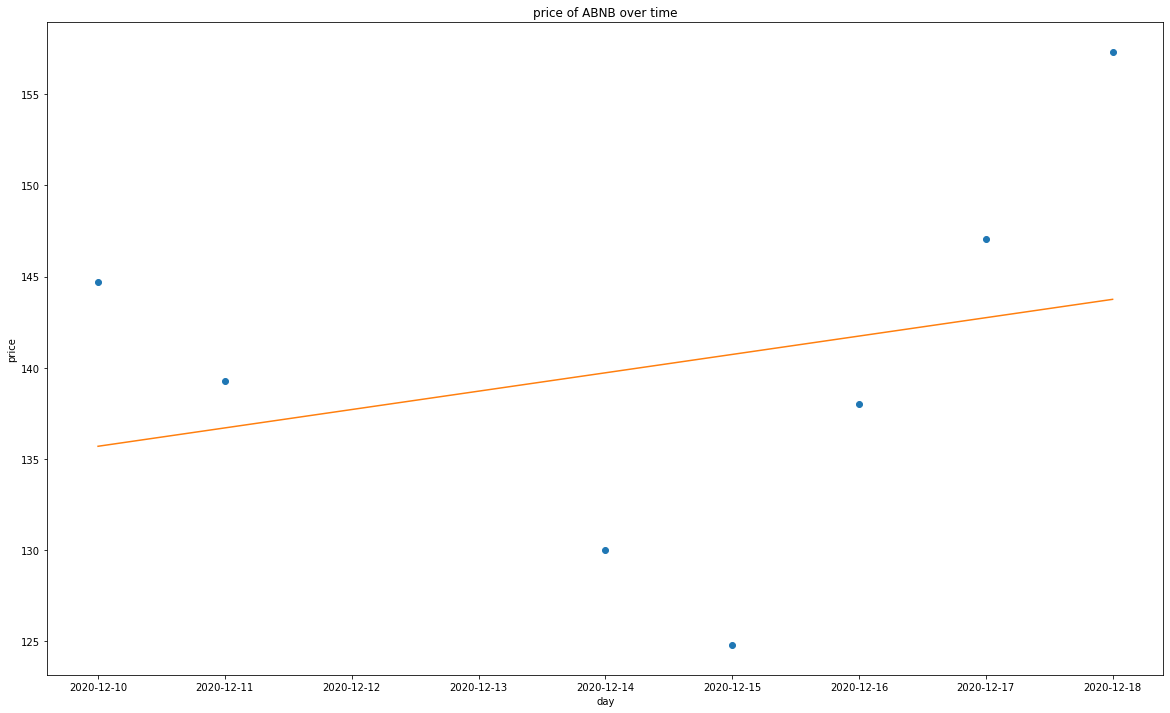

ABNB


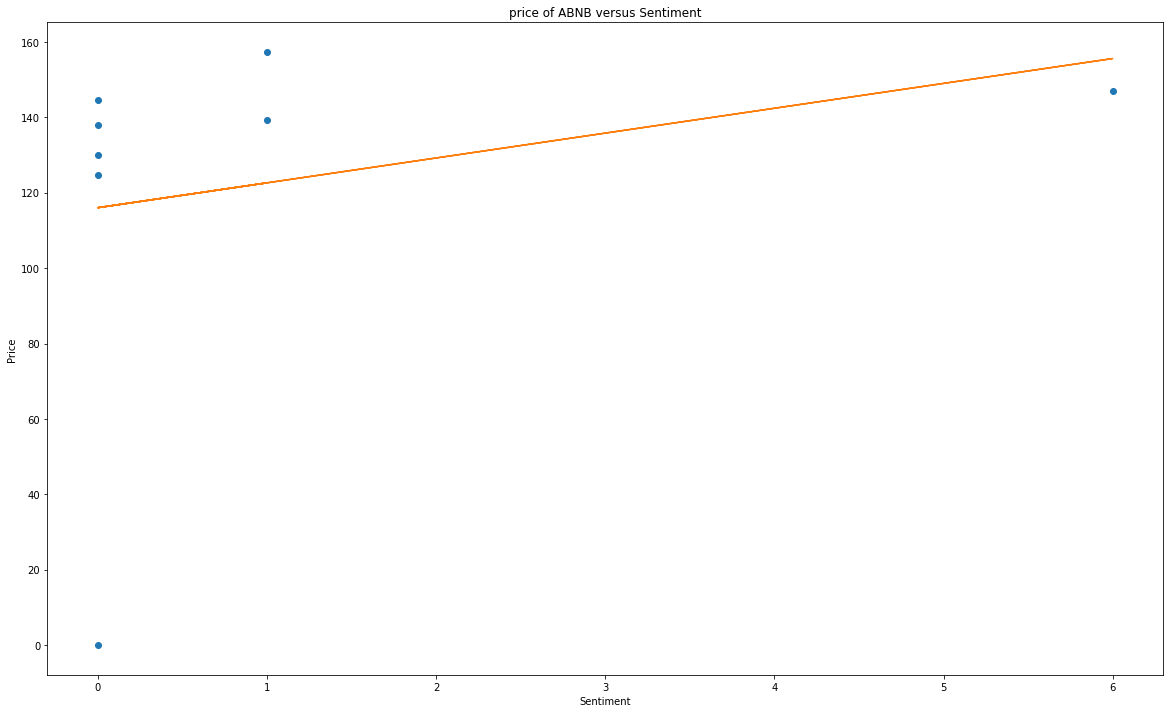

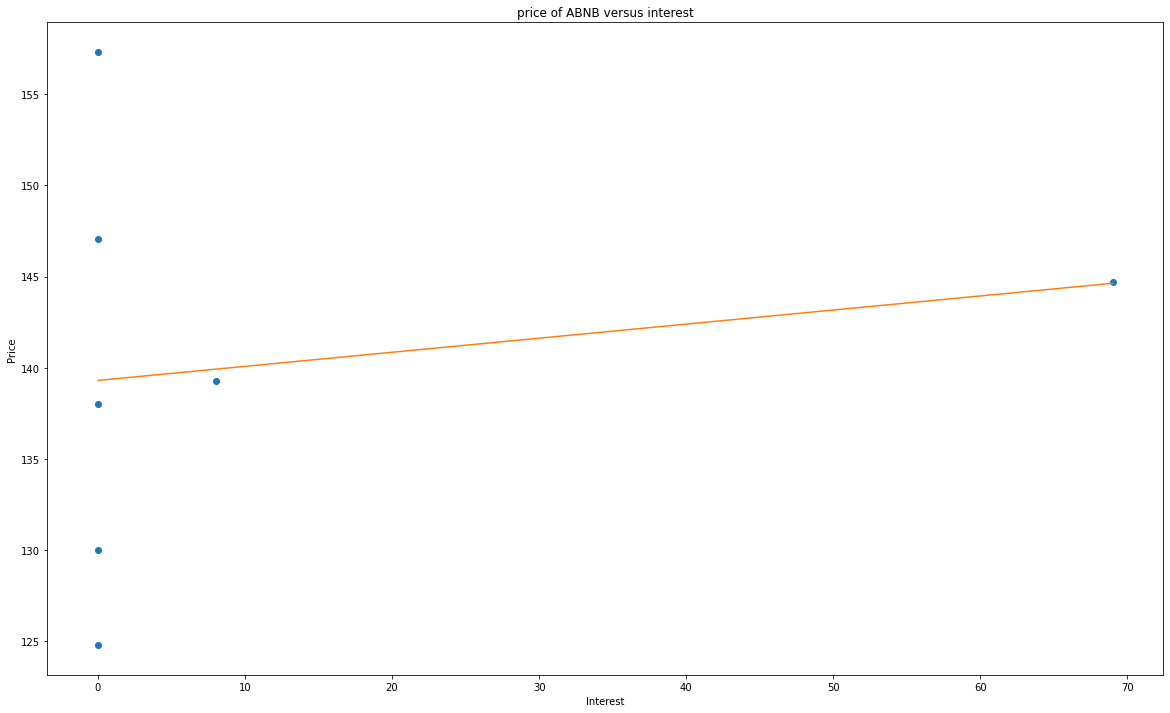

In [15]:
for i in range(0, 5):
    lin_reg_time(fetch_stocks[i])
    lin_reg_sentiment(fetch_stocks[i])
    lin_reg_interest(fetch_stocks[i])

<div style = "background-color: lightcoral;">
    <p style = "font-size: 20px"><strong>Understanding good comments with ML</strong></p>
</div>
<p> In the following cells we will be attempting to understand what makes a good comment on wall street bets. The importance of understand what makes good comments is based around the idea of limiting the scope of the data we need to look at. If we can understand what good comments look like then we can further direct our attention to understanding what the best traders on wall street bets are doing with their money.</p>

In [16]:

import pandas as pd
import statistics
import math
from sklearn.model_selection import train_test_split
from itertools import islice


words = ['PUT','PUTS' ,'SOLD' ,'DOWN' , 'SHORT','BULL', 'BULLS', 'CALL' , 'CALLS' , 'BOUGHT' , 'UP', 'LONG', 'BEAR', 'BEARS']
    
curses = ["FUCK", "SHIT", "WTF"]


x_data = []
y_data = [0,0,0,1,0,1,0,0,0,1,
          0,0,0,0,1,0,1,0,1,0,
          0,0,0,1,1,0,1,1,0,1,
          0,0,0,0,0,1,0,0,0,0,
          0,1,0,0,1,0,1,0,0,0,
          0,1,0,1,1,0,0,0,1,0,
          0,0,0,1,0,1,1,0,0,0,
          0,0,0,1,0,0,0,1,0,0,
          1,0,1,0,1,0,1,0,1,1,
          0,0,0,0,0,0,0,0,0,0]


for i, row in islice(wsb.iterrows(), 0, 100):
    comment = row['comment']
    capital_comment = comment.upper()
    to_append = []
    
    #measuring length of comment
    to_append.append(len(comment))
         
    #counting up trigger words
    count = 0
    for word in words:
         if word in capital_comment:
            count = count + capital_comment.count(word)
    to_append.append(count)
    
    #counting up curse words
    curse_count = 0
    for curse in curses:
        if curse in capital_comment:
            curse_count = curse_count + capital_comment.count(curse)
    to_append.append(curse_count)
    capital_count = 0
    
    #counting up captital letters
    to_append.append(sum(1 for c in comment if c.isupper()))
    
    #upvotes of comment
    to_append.append(row['upvotes'])
    #replies to comment
    to_append.append(row['interaction'])
  
    x_data.append(to_append)

x_train, x_final, y_train, y_final = train_test_split(x_data,y_data,test_size = .4)


# this data set takes a variety of different predictors for breast cancer
# and provides a way to predict whether someone actually has the cancer based on these
# indicators.
# the target variable is whether an individual has breast cancer, the independent variables are 
# mean radius  mean texture  mean perimeter  mean area  mean smoothness and so on of similar nature

# k-NN classification
from sklearn.neighbors import KNeighborsClassifier
neighbor = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
neighbor.fit(x_train, y_train)
res2 = neighbor.predict(x_final)
print(res2)
print(neighbor.score(x_final, y_final))

# 10-fold cross-validation procedure
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(neighbor, x_final, y_final, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

# Paired T-Test Calculation
def p_test(res2, y_final):
    diff = []
    for i in range(len(res2)): 
        diff.append(res2[i] - y_final[i])

    print("t = ",(sum(diff)/len(diff))/(np.std(diff)/math.sqrt(len(diff))))
# k-NN classification t-test
p_test(res2, y_final)

[0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0]
0.625
Accuracy: 0.70 (+/- 0.37)
t =  -1.3187609467915744


# Conclusion

Based off our earlier observations and analysis we can see that metrics such as interest and sentiment 


You can learn more about using sentiment analysis for understanding the stock market at the following links

<p><strong>Sentiment Analysis of Stocks from Financial News using Python</strong></p>
<a href= https://towardsdatascience.com/sentiment-analysis-of-stocks-from-financial-news-using-python-82ebdcefb638> click here to read more</a>

<p><strong>How Sentiment Analysis in Stock Market Used for Right Prediction?</strong></p>
<a href= https://medium.com/vsinghbisen/how-sentiment-analysis-in-stock-market-used-for-right-prediction-5c1bfe64c233> click here to read more</a>
